In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import geopandas
from shapely.geometry import mapping
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice, get_GWL_syear_eyear
sys.path.append('/g/data/mn51/users/jb6465/drought-github')
import utils

In [1]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [2]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

In [4]:
spi_dir = '/g/data/dx2/jb6465/spi_pandora'
spi_36_ACCESS_ESM1_5 = xr.open_dataset(f'{spi_dir}/SPI36_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD.nc')
spi_3_ACCESS_ESM1_5 = xr.open_dataset(f'{spi_dir}/SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD.nc')

spi_36_AGCD = xr.open_dataset(f'{spi_dir}/AGCD_SPI36_baseperiod_1965_2014.nc')
spi_3_AGCD = xr.open_dataset(f'{spi_dir}/AGCD_SPI3_baseperiod_1965_2014.nc')

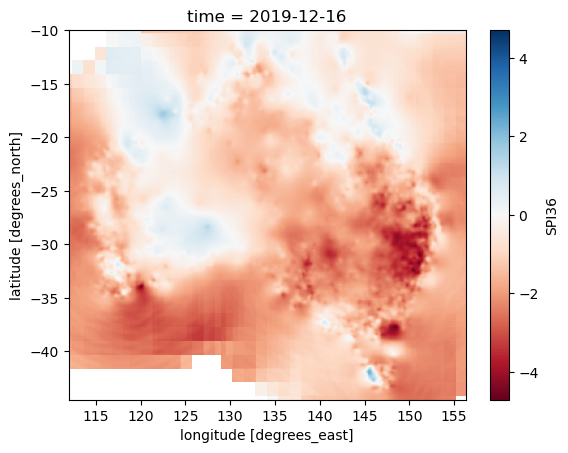

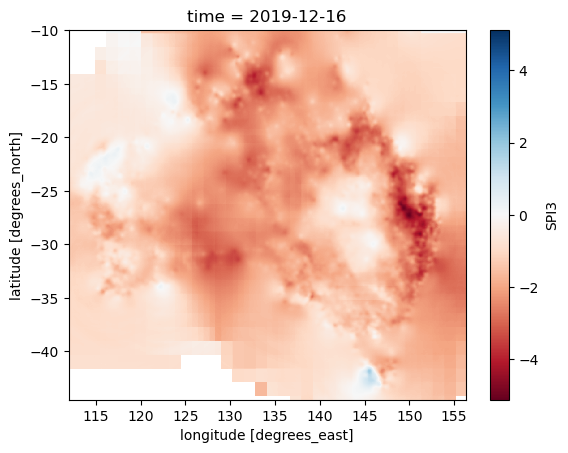

<Figure size 640x480 with 0 Axes>

In [5]:
# quick inspection of AGCD SPI with rainfall decile maps to check
# http://www.bom.gov.au/climate/maps/rainfall/?variable=rainfall&map=decile&period=36month&region=nat&year=2019&month=12&day=31
spi_36_AGCD.SPI36[719,:,:].plot(cmap='RdBu')
plt.show()
plt.clf()
# http://www.bom.gov.au/climate/maps/rainfall/?variable=rainfall&map=decile&period=3month&region=nat&year=2019&month=12&day=31
spi_3_AGCD.SPI3[719,:,:].plot(cmap='RdBu')
plt.show()
plt.clf()

### Plotting using ACS plotting library

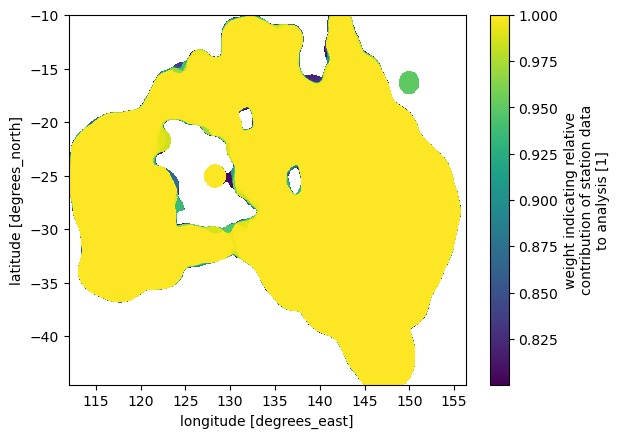

In [17]:
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc")
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)
mask_ds.fraction.where(q_mask.mask).plot()

CPU times: user 7.39 s, sys: 632 ms, total: 8.02 s
Wall time: 8.05 s


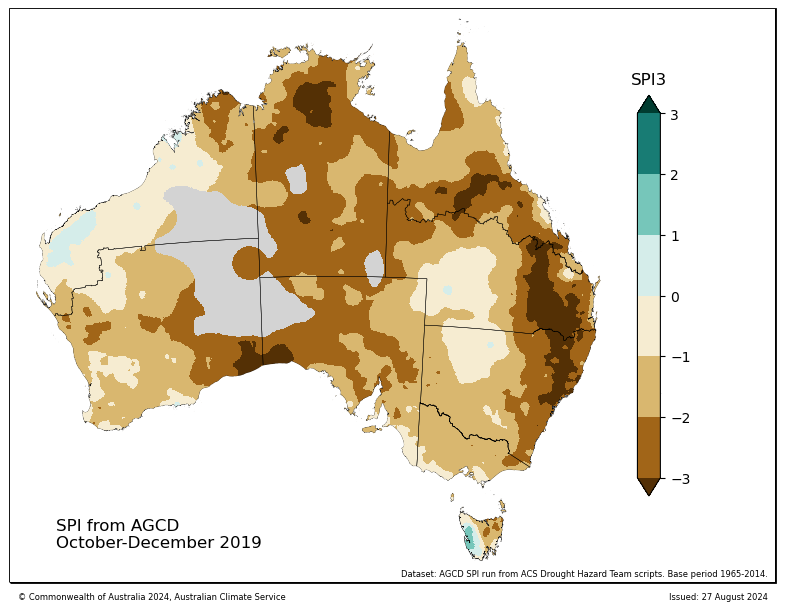

In [22]:
%%time

cmap_grey_mask = cmap_dict["pr_anom"]
cmap_grey_mask.set_bad(color="lightgrey")

plot_acs_hazard(data = spi_3_AGCD.sel(time='2019-12-16').SPI3.where(q_mask.mask),
                regions = regions_dict['ncra_regions'],
                cmap = cmap_grey_mask,
                ticks = np.arange(-3, 3.1, 1),
                cbar_label = "SPI3",
                cbar_extend = "both",
                title = "SPI from AGCD",
                dataset_name = "AGCD SPI run from ACS Drought Hazard Team scripts. Base period 1965-2014.",
                date_range = "October-December 2019",
                contourf = False,
                contour = False,
                watermark= None,
                outfile = "/g/data/dx2/jb6465/spi_pandora/plots/AGCD_SPI3_Oct-Dec_2019_masked.png" 
               );

CPU times: user 1min 57s, sys: 817 ms, total: 1min 58s
Wall time: 1min 58s


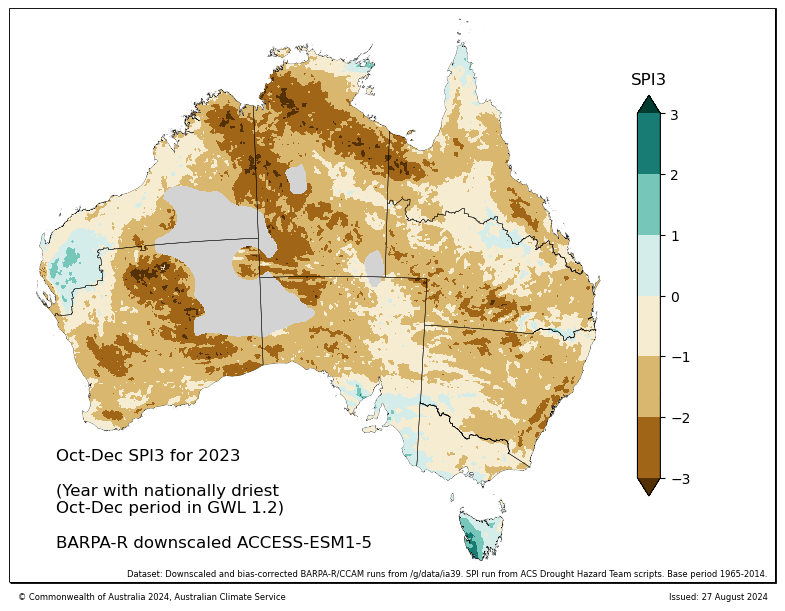

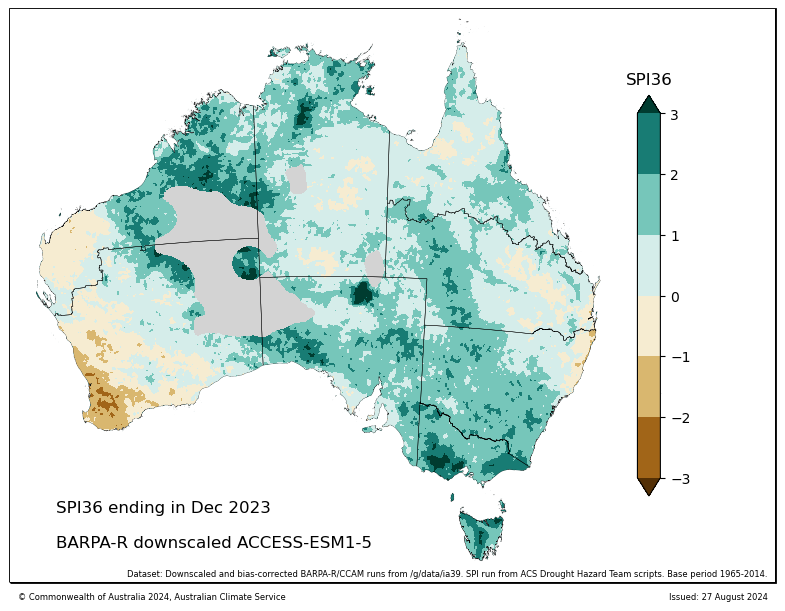

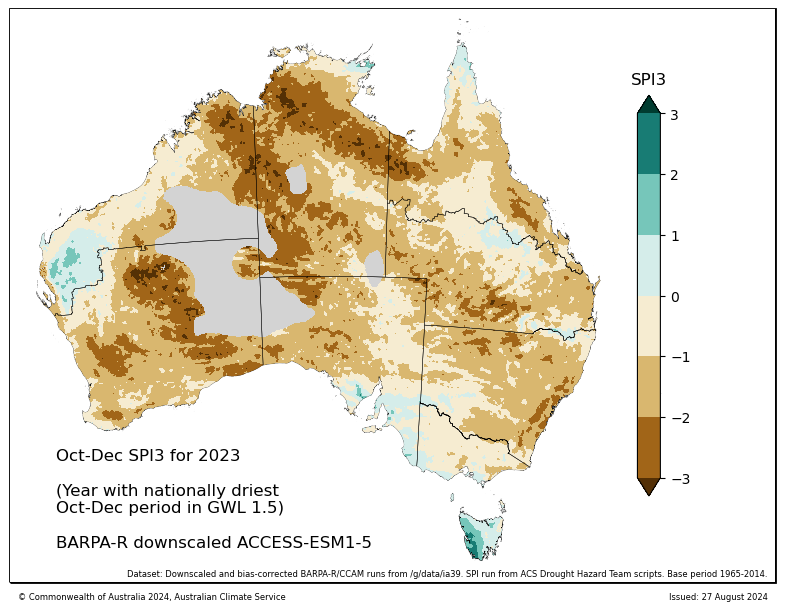

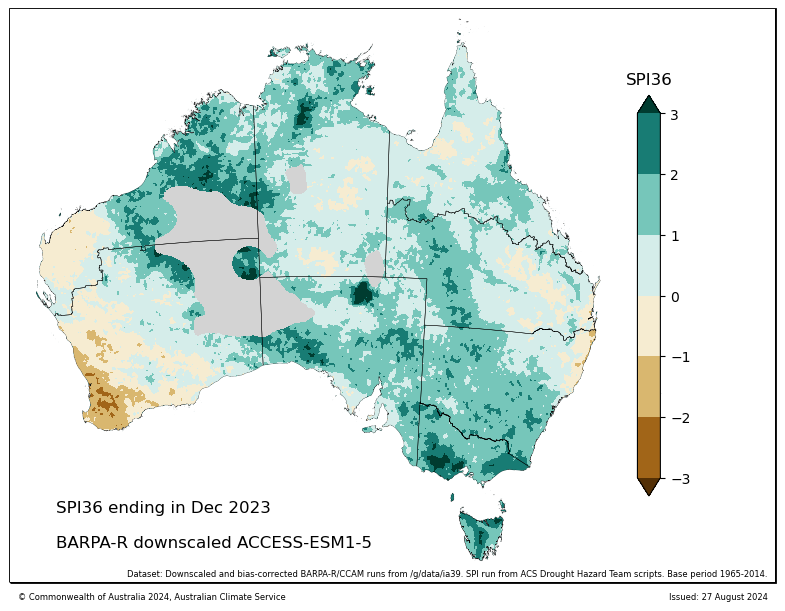

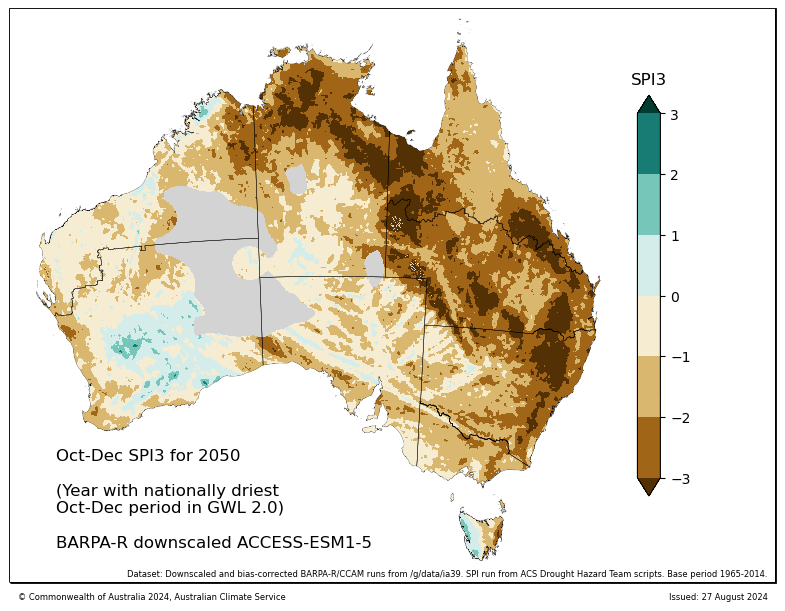

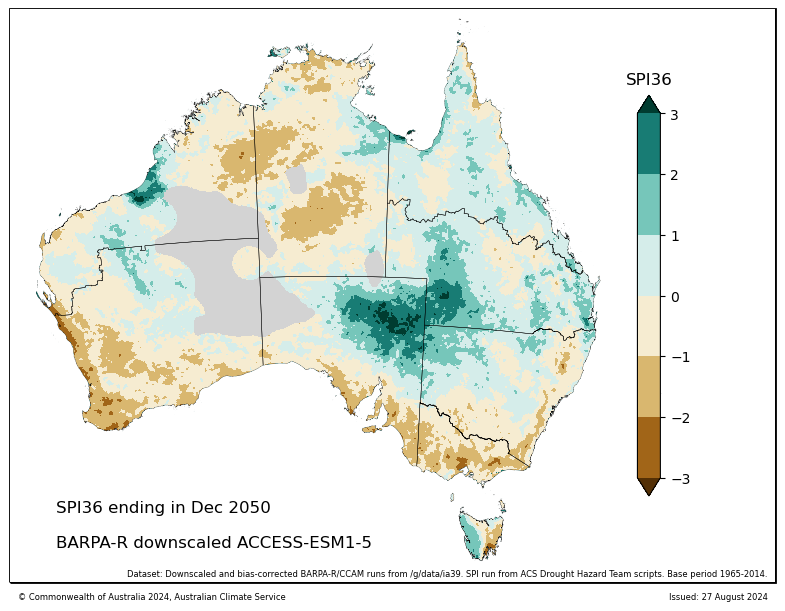

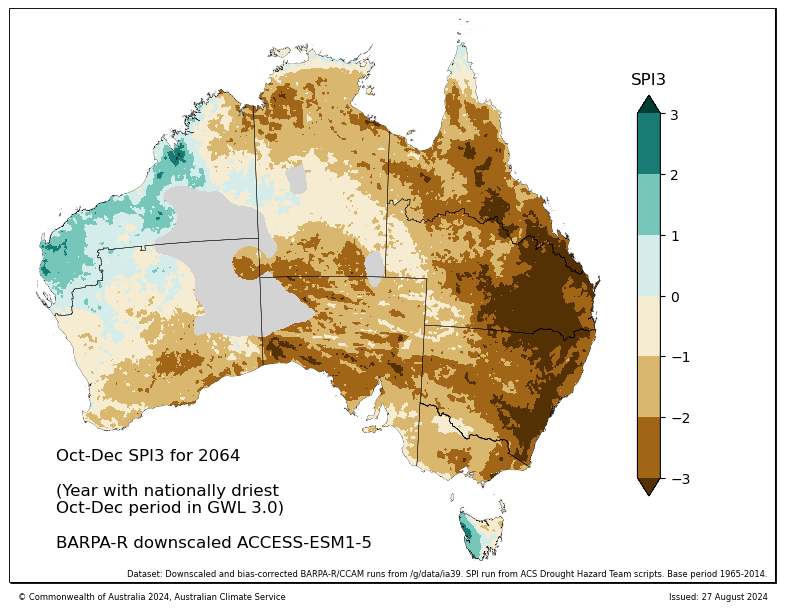

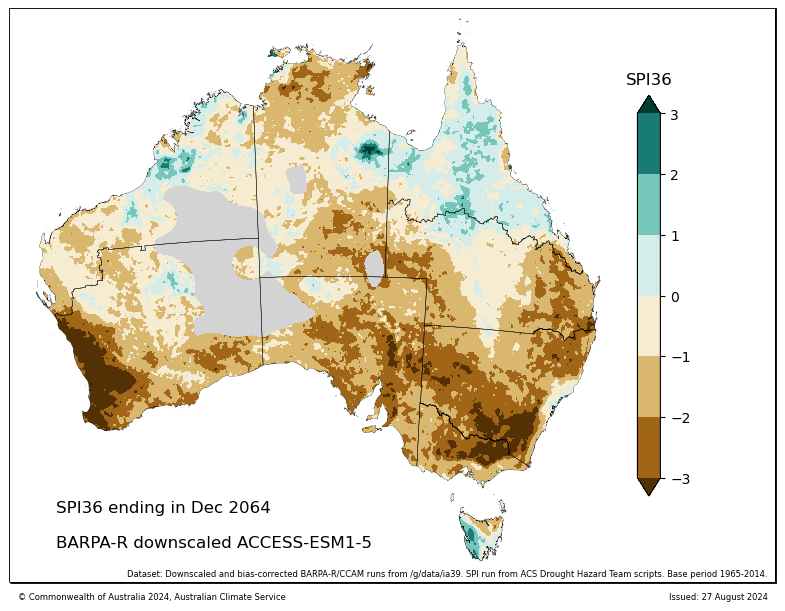

In [34]:
%%time

cmap_grey_mask = cmap_dict["pr_anom"]
cmap_grey_mask.set_bad(color="lightgrey")

for GWL in ['1.2', '1.5', '2.0', '3.0']:
    GWLtarget_slice = get_GWL_timeslice(spi_3_ACCESS_ESM1_5,'CMIP6','ACCESS-ESM1-5','r6i1p1f1','ssp370',GWL)
    GWLtarget_slice_oct_dec_av = GWLtarget_slice.sel(time=GWLtarget_slice.time.dt.month == 12)
    mean_SPI3 = GWLtarget_slice_oct_dec_av.SPI3.where(~np.isinf(GWLtarget_slice_oct_dec_av.SPI3)).mean(dim=['lat', 'lon'], skipna=True)
    time_idx_driest_year_in_timeslice = mean_SPI3.values.argmin()
    
    plot_acs_hazard(data = GWLtarget_slice_oct_dec_av.SPI3[time_idx_driest_year_in_timeslice,:,:].where(q_mask.mask),
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_grey_mask,
                    ticks = np.arange(-3, 3.1, 1),
                    cbar_label = "SPI3",
                    cbar_extend = "both",
                    title = f"Oct-Dec SPI3 for {str(GWLtarget_slice_oct_dec_av.time.values[time_idx_driest_year_in_timeslice])[0:4]}\n \n(Year with nationally driest \nOct-Dec period in GWL {GWL})\n",
                    dataset_name = "Downscaled and bias-corrected BARPA-R/CCAM runs from /g/data/ia39. SPI run from ACS Drought Hazard Team scripts. Base period 1965-2014.",
                    date_range = "BARPA-R downscaled ACCESS-ESM1-5",
                    contourf = False,
                    contour = False,
                    watermark= None,
                    outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/ACCESS-ESM1-5_SPI3_driest_Oct-Dec_GWL{GWL}_masked.png" 
                   );
    spi36_GWLtarget_slice = get_GWL_timeslice(spi_36_ACCESS_ESM1_5,'CMIP6','ACCESS-ESM1-5','r6i1p1f1','ssp370',GWL).sel(time=GWLtarget_slice.time.dt.month == 10)
    plot_acs_hazard(data = spi36_GWLtarget_slice.SPI36[time_idx_driest_year_in_timeslice,:,:].where(q_mask.mask),
                regions = regions_dict['ncra_regions'],
                cmap = cmap_grey_mask,
                ticks = np.arange(-3, 3.1, 1),
                cbar_label = "SPI36",
                cbar_extend = "both",
                title = f"SPI36 ending in Dec {str(spi36_GWLtarget_slice.time.values[time_idx_driest_year_in_timeslice])[0:4]}\n",
                dataset_name = "Downscaled and bias-corrected BARPA-R/CCAM runs from /g/data/ia39. SPI run from ACS Drought Hazard Team scripts. Base period 1965-2014.",
                date_range = "BARPA-R downscaled ACCESS-ESM1-5",
                contourf = False,
                contour = False,
                watermark= None,
                outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/ACCESS-ESM1-5_SPI36_preceding_driestOctDec_GWL{GWL}_masked.png" 
               );

CPU times: user 8.02 s, sys: 179 ms, total: 8.2 s
Wall time: 8.48 s


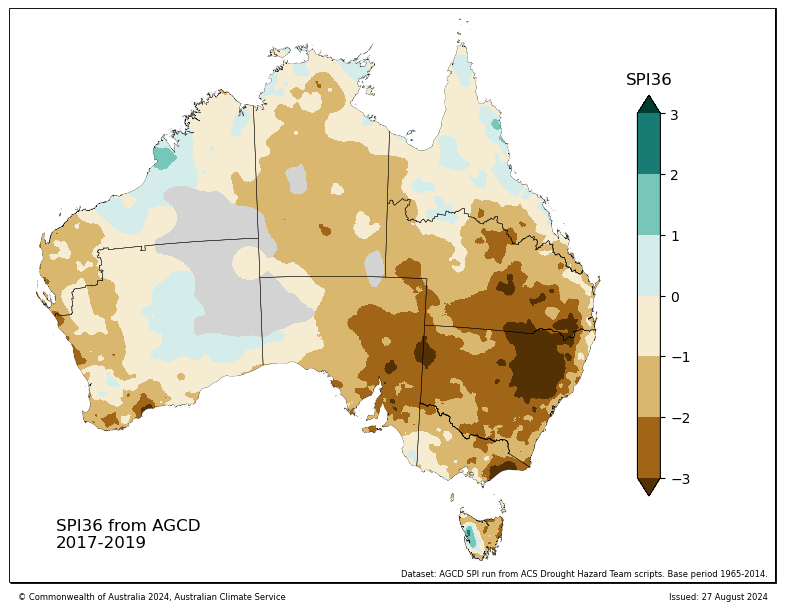

In [24]:
%%time

cmap_grey_mask = cmap_dict["pr_anom"]
cmap_grey_mask.set_bad(color="lightgrey")

plot_acs_hazard(data = spi_36_AGCD.sel(time='2019-12-16').SPI36.where(q_mask.mask),
                regions = regions_dict['ncra_regions'],
                cmap = cmap_grey_mask,
                ticks = np.arange(-3, 3.1, 1),
                cbar_label = "SPI36",
                cbar_extend = "both",
                title = "SPI36 from AGCD",
                dataset_name = "AGCD SPI run from ACS Drought Hazard Team scripts. Base period 1965-2014.",
                date_range = "2017-2019",
                contourf = False,
                contour = False,
                watermark= None,
                # show_logo=True,
                outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/AGCD_SPI36_2017_2019_masked.png" 
               );

CPU times: user 1min 8s, sys: 651 ms, total: 1min 8s
Wall time: 1min 9s


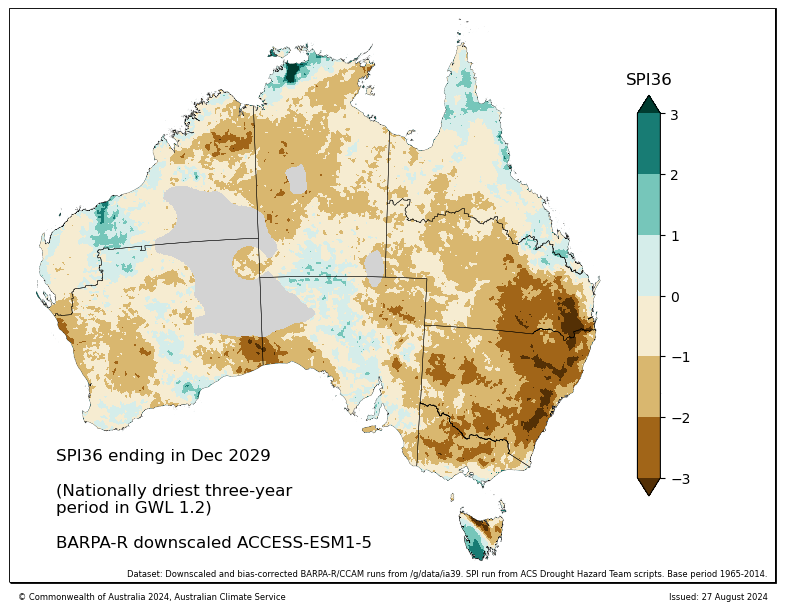

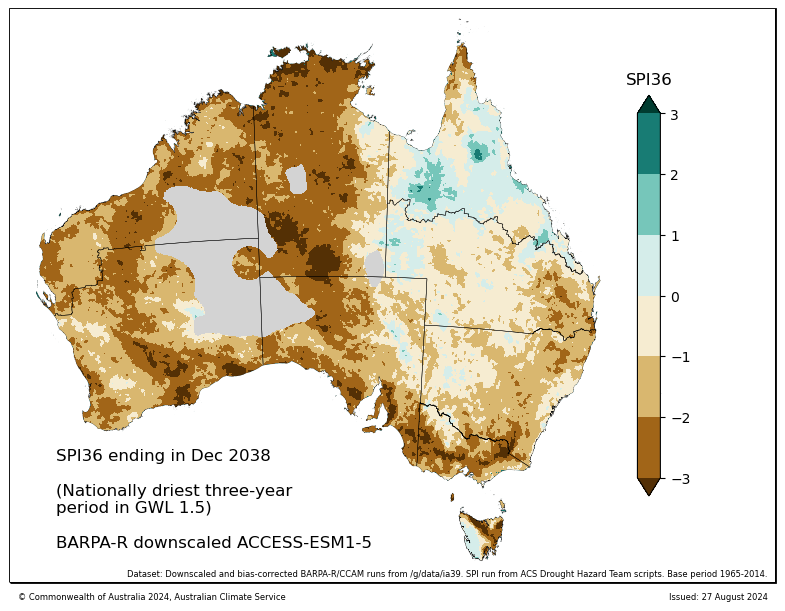

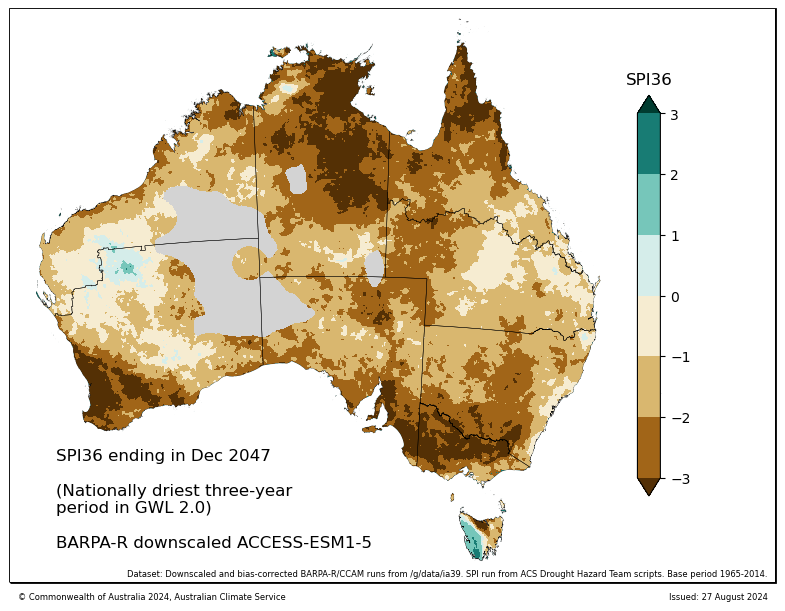

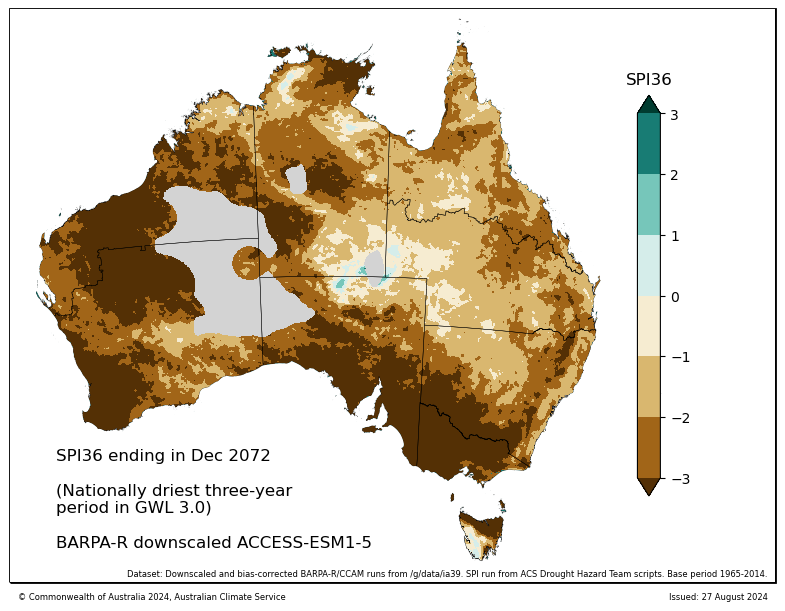

In [25]:
%%time
cmap_grey_mask = cmap_dict["pr_anom"]
cmap_grey_mask.set_bad(color="lightgrey")

for GWL in ['1.2', '1.5', '2.0', '3.0']:
    GWLtarget_slice = get_GWL_timeslice(spi_36_ACCESS_ESM1_5,'CMIP6','ACCESS-ESM1-5','r6i1p1f1','ssp370',GWL)
    GWLtarget_slice_oct_dec_av = GWLtarget_slice.sel(time=GWLtarget_slice.time.dt.month == 12)
    mean_SPI36 = GWLtarget_slice_oct_dec_av.SPI36.where(~np.isinf(GWLtarget_slice_oct_dec_av.SPI36)).mean(dim=['lat', 'lon'], skipna=True)
    time_idx_driest_year_in_timeslice = mean_SPI36.values.argmin()
    
    plot_acs_hazard(data = GWLtarget_slice_oct_dec_av.SPI36[time_idx_driest_year_in_timeslice,:,:].where(q_mask.mask),
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_grey_mask,
                    ticks = np.arange(-3, 3.1, 1),
                    cbar_label = "SPI36",
                    cbar_extend = "both",
                    title = f"SPI36 ending in Dec {str(GWLtarget_slice_oct_dec_av.time.values[time_idx_driest_year_in_timeslice])[0:4]}\n \n(Nationally driest three-year \nperiod in GWL {GWL})\n",
                    dataset_name = "Downscaled and bias-corrected BARPA-R/CCAM runs from /g/data/ia39. SPI run from ACS Drought Hazard Team scripts. Base period 1965-2014.",
                    date_range = "BARPA-R downscaled ACCESS-ESM1-5",
                    contourf = False,
                    contour = False,
                    watermark= None,
                    outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/ACCESS-ESM1-5_SPI36_driest_GWL{GWL}_masked.png" 
                   );

In [5]:
def GWL_plot_change_oct_dec(input_xr, GWL):
    cmap_grey_mask = cmap_dict["anom_r"]
    cmap_grey_mask.set_bad(color="lightgrey")
    
    GWL12_slice = get_GWL_timeslice(input_xr,'CMIP6','ACCESS-ESM1-5','r6i1p1f1','ssp370',1.2)
    GWL12_slice_oct_dec_av = GWL12_slice.sel(time=GWL12_slice.time.dt.month == 12).mean(dim='time')
    GWL12_slice_oct_dec_av = GWL12_slice_oct_dec_av[list(GWL12_slice_oct_dec_av.data_vars)[0]]
    
    GWLtarget_slice = get_GWL_timeslice(input_xr,'CMIP6','ACCESS-ESM1-5','r6i1p1f1','ssp370',GWL)
    GWLtarget_slice_oct_dec_av = GWLtarget_slice.sel(time=GWLtarget_slice.time.dt.month == 12).mean(dim='time')
    GWLtarget_slice_oct_dec_av = GWLtarget_slice_oct_dec_av[list(GWLtarget_slice_oct_dec_av.data_vars)[0]]

    plot_acs_hazard(data = GWLtarget_slice_oct_dec_av-GWL12_slice_oct_dec_av.where(q_mask.mask),
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_grey_mask,
                    ticks = np.arange(-1, 1.1, 0.25),
                    cbar_label = f"{list(GWL12_slice.data_vars)[0]} change",
                    cbar_extend = "both",
                    title = "Absolute change in average Oct-Dec SPI3\n" if list(GWL12_slice.data_vars)[0][3:]=='3' else "Absolute change in average SPI36 ending in Dec\n",
                    dataset_name = "Downscaled and bias-corrected BARPA-R/CCAM runs from /g/data/ia39. SPI run from ACS Drought Hazard Team scripts. Base period 1965-2014.",
                    date_range = f"GWL{GWL} - GWL1.2\nfrom BARPA-R downscaled ACCESS-ESM1-5",
                    contourf = False,
                    contour = False,
                    watermark= None,
                    outfile = f"/g/data/dx2/jb6465/spi_pandora/plots/ACCESS-ESM1-5_SPI{list(GWL12_slice.data_vars)[0][3:]}_Oct_Dec_GWL{GWL}_GWL12_change_masked.png" 
                   );
    return 

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 1min 19s, sys: 740 ms, total: 1min 20s
Wall time: 1min 20s


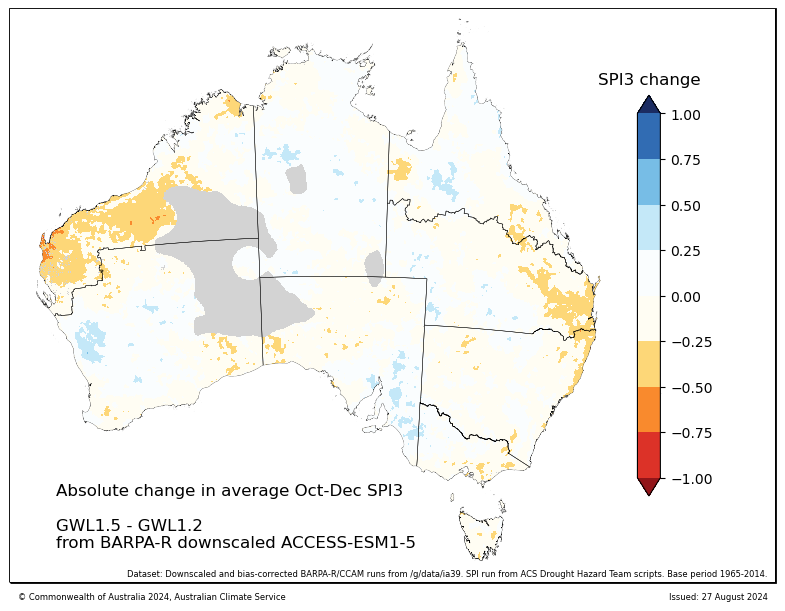

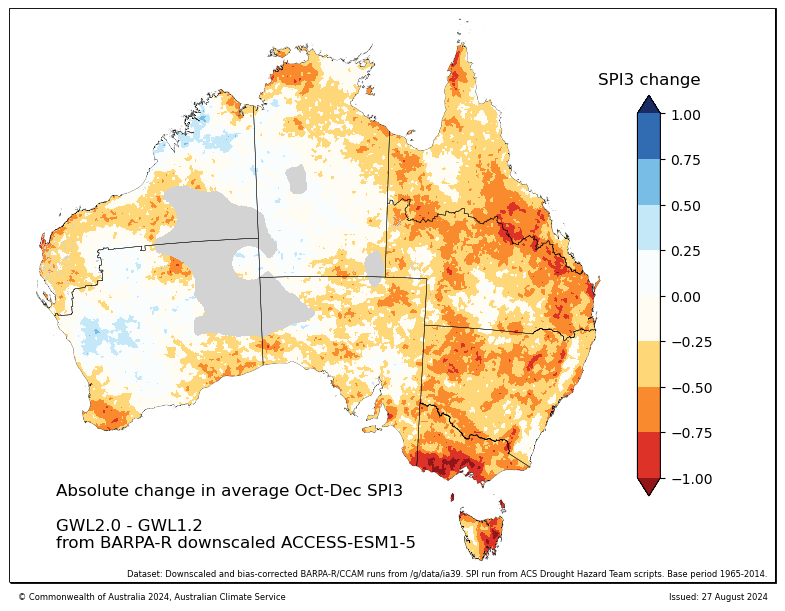

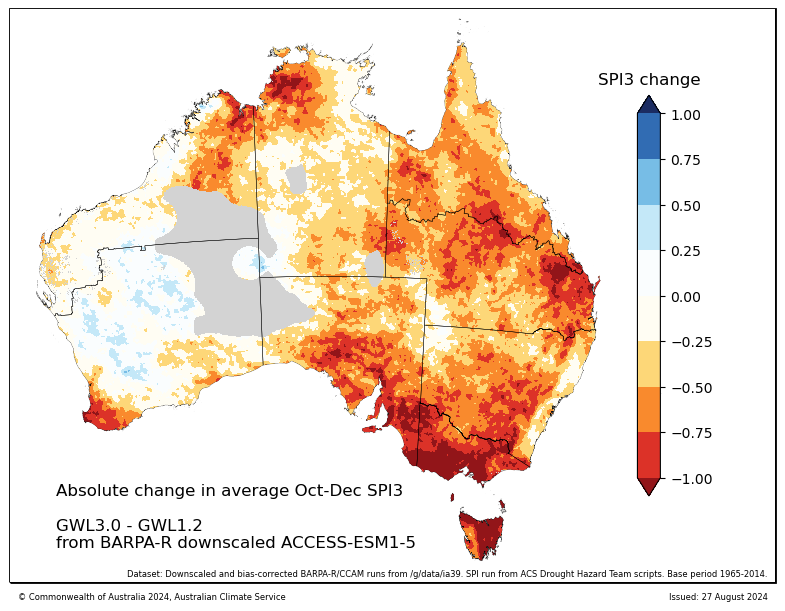

In [27]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    GWL_plot_change_oct_dec(spi_3_ACCESS_ESM1_5, GWL)

CPU times: user 1min 19s, sys: 757 ms, total: 1min 20s
Wall time: 1min 21s


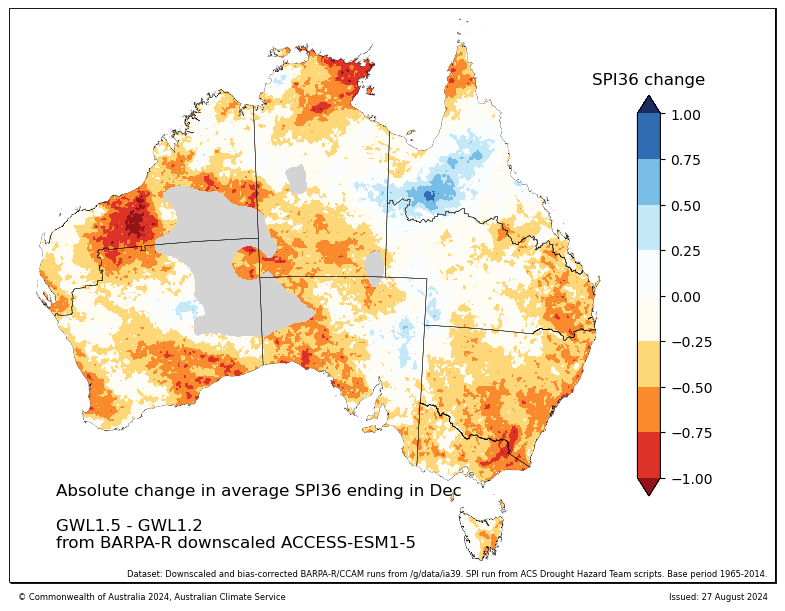

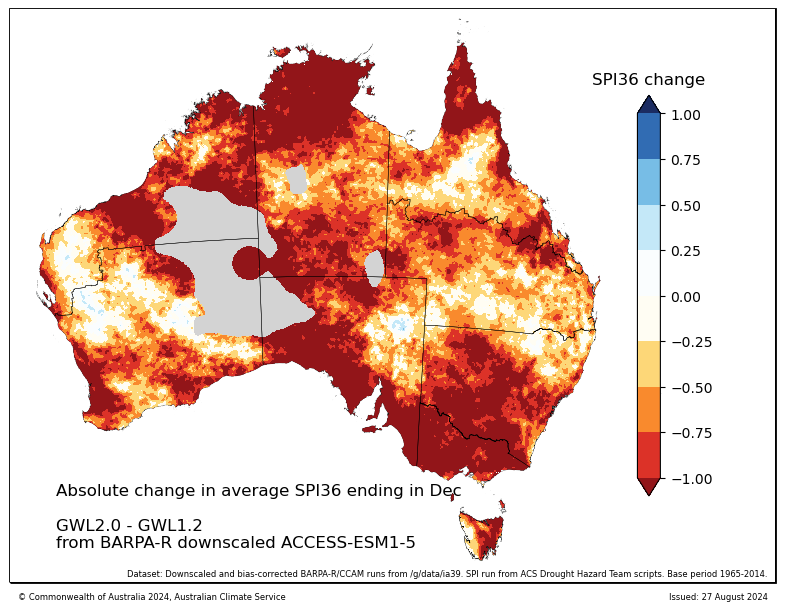

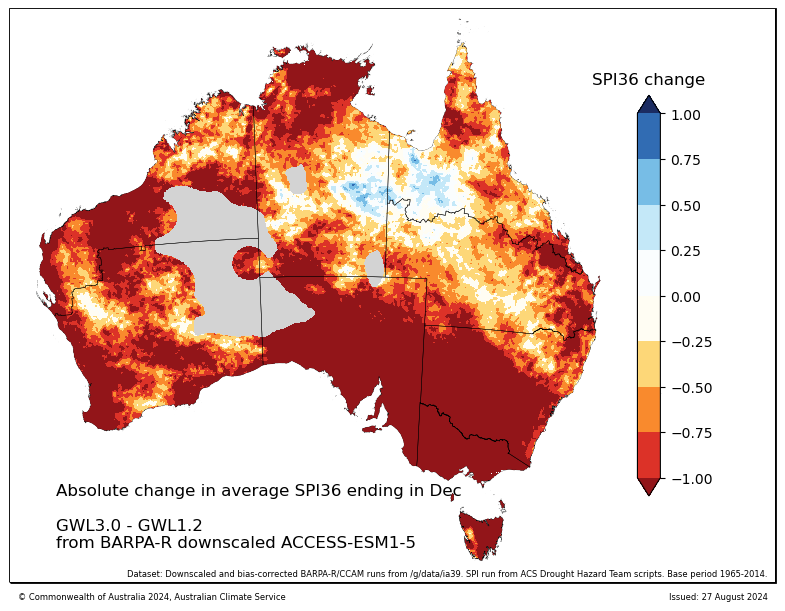

In [28]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    GWL_plot_change_oct_dec(spi_36_ACCESS_ESM1_5, GWL)

In [16]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f'GWL{GWL} for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:')
    print(get_GWL_syear_eyear('CMIP6', 'ACCESS-ESM1-5', 'r6i1p1f1', 'ssp370', GWL))
    print()


GWL1.2 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2015 2034]

GWL1.5 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2023 2042]

GWL2.0 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2035 2054]

GWL3.0 for ACCESS-ESM1-5 (r6i1p1f1) at SSP3.70:
[2062 2081]



### MSLP

In [1]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43729 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43729/status,
Dashboard: /proxy/43729/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45567,Workers: 10
Dashboard: /proxy/43729/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:41029,Total threads: 1
Dashboard: /proxy/35189/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:41379,


In [2]:
def extract_BARPA_files(variable_name, accumulation):
    cmip6_hist = f'/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/mon/{variable_name}/v20231001/'
    cmip6_ssp370 = f'/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/ssp370/r6i1p1f1/BARPA-R/v1-r1/mon/{variable_name}/v20231001/'
    
    files = []
    for i in range(1960,2100):
        files.extend(sorted(glob.glob("{}/*{}".format(cmip6_hist, str(i)+'12.nc'))))
        files.extend(sorted(glob.glob("{}/*{}".format(cmip6_ssp370, str(i)+'12.nc'))))
        
    BARPA_var = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True).chunk({'time':-1, 'lat':'auto', 'lon':'auto'})[variable_name]
    BARPA_var_accumulated = BARPA_var.rolling(time=int(accumulation), center=False).mean().sel(time=slice(BARPA_var.time[12], None))
    BARPA_var_clim = BARPA_var_accumulated.sel(time=slice('1965-01-16', '2014-12-16'))
    BARPA_var_clim = BARPA_var_clim.sel(time=BARPA_var_clim.time.dt.month == 12)
    
    BARPA_var_GWL3 = BARPA_var_accumulated.sel(time=slice('2062-01-16', '2081-12-16'))
    BARPA_Oct_Dec_var_GWL3 = (BARPA_var_GWL3.sel(time=BARPA_var_GWL3.time.dt.month == 12))
    
    BARPA_var_GWL2 = BARPA_var_accumulated.sel(time=slice('2035-01-16', '2054-12-16'))
    BARPA_Oct_Dec_var_GWL2 = (BARPA_var_GWL2.sel(time=BARPA_var_GWL2.time.dt.month == 12))
    
    BARPA_var_GWL15 = BARPA_var_accumulated.sel(time=slice('2023-01-16', '2042-12-16'))
    BARPA_Oct_Dec_var_GWL15 = (BARPA_var_GWL15.sel(time=BARPA_var_GWL15.time.dt.month == 12))
    
    BARPA_var_GWL12 = BARPA_var_accumulated.sel(time=slice('2015-01-16', '2034-12-16'))
    BARPA_Oct_Dec_var_GWL12 = (BARPA_var_GWL12.sel(time=BARPA_var_GWL12.time.dt.month == 12))

    return BARPA_var_clim, BARPA_Oct_Dec_var_GWL3, BARPA_Oct_Dec_var_GWL2, BARPA_Oct_Dec_var_GWL15, BARPA_Oct_Dec_var_GWL12

In [6]:
BARPA_psl_clim, BARPA_Oct_Dec_psl_GWL3, BARPA_Oct_Dec_psl_GWL2, BARPA_Oct_Dec_psl_GWL15, BARPA_Oct_Dec_psl_GWL12 = extract_BARPA_files('psl', 3)

In [7]:
BARPA_ua850_clim, BARPA_Oct_Dec_ua850_GWL3, BARPA_Oct_Dec_ua850_GWL2, BARPA_Oct_Dec_ua850_GWL15, BARPA_Oct_Dec_ua850_GWL12 = extract_BARPA_files('ua850', 3)

In [8]:
BARPA_va850_clim, BARPA_Oct_Dec_va850_GWL3, BARPA_Oct_Dec_va850_GWL2, BARPA_Oct_Dec_va850_GWL15, BARPA_Oct_Dec_va850_GWL12 = extract_BARPA_files('va850', 3)

In [36]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import box

/jobfs/124901903.gadi-pbs/ipykernel_1609778/1438534297.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


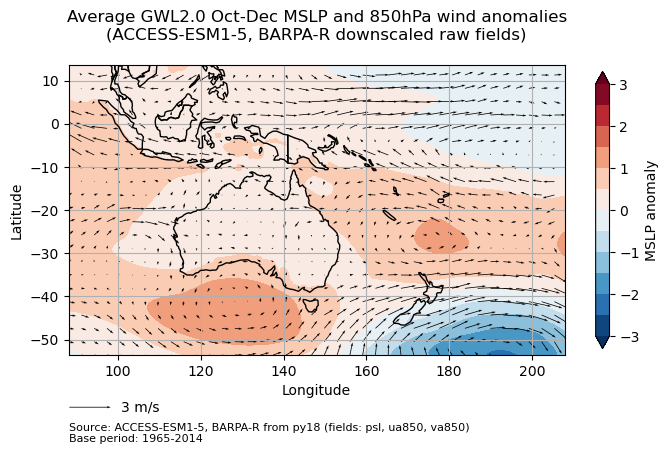

In [10]:
GWL2_av_oct_dec_MSLP_anom = BARPA_Oct_Dec_psl_GWL2.mean(dim='time')/100 - BARPA_psl_clim.mean(dim='time')/100
GWL2_av_oct_dec_ua850_anom = BARPA_Oct_Dec_ua850_GWL2.mean(dim='time') - BARPA_ua850_clim.mean(dim='time')
GWL2_av_oct_dec_va850_anom = BARPA_Oct_Dec_va850_GWL2.mean(dim='time') - BARPA_va850_clim.mean(dim='time')

fig, ax = plt.subplots(figsize=(8, 6))
mslp = plt.contourf(GWL2_av_oct_dec_MSLP_anom.lon, GWL2_av_oct_dec_MSLP_anom.lat, GWL2_av_oct_dec_MSLP_anom, cmap='RdBu_r', levels=np.linspace(-3, 3.0, 13), extend='both')
windanom = ax.quiver(GWL2_av_oct_dec_ua850_anom.lon[::20], GWL2_av_oct_dec_ua850_anom.lat[::20], 
                     GWL2_av_oct_dec_ua850_anom[::20, ::20], GWL2_av_oct_dec_va850_anom[::20, ::20], 
                     scale_units='xy', scale=0.3, width=0.0015)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average GWL2.0 Oct-Dec MSLP and 850hPa wind anomalies\n(ACCESS-ESM1-5, BARPA-R downscaled raw fields)\n')

plt.quiverkey(windanom, 0.085, -0.18, 3, str(3) + ' m/s', labelpos='E', coordinates='axes')
ax.grid(True)
plt.colorbar(mslp, ax=ax, orientation='vertical', label='MSLP anomaly', shrink=0.6)

lon_min, lon_max = GWL2_av_oct_dec_MSLP_anom.lon.min(), GWL2_av_oct_dec_MSLP_anom.lon.max()
lat_min, lat_max = GWL2_av_oct_dec_MSLP_anom.lat.min(), GWL2_av_oct_dec_MSLP_anom.lat.max()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
bbox = box(lon_min, lat_min, lon_max, lat_max)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=world.crs)
world_clipped = world.clip(bbox_gdf.unary_union)
world_clipped.boundary.plot(ax=ax, linewidth=1, color='black')

ax.text(0, -0.3, 'Source: ACCESS-ESM1-5, BARPA-R from py18 (fields: psl, ua850, va850)\nBase period: 1965-2014', transform=ax.transAxes, 
        fontsize=8, ha='left', color='black')


plt.show()


/jobfs/124901903.gadi-pbs/ipykernel_1609778/652698572.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


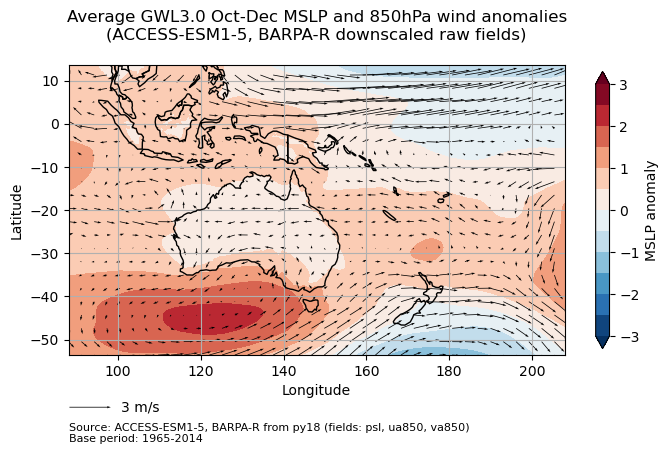

In [11]:

GWL3_av_oct_dec_MSLP_anom = BARPA_Oct_Dec_psl_GWL3.mean(dim='time')/100 - BARPA_psl_clim.mean(dim='time')/100
GWL3_av_oct_dec_ua850_anom = BARPA_Oct_Dec_ua850_GWL3.mean(dim='time') - BARPA_ua850_clim.mean(dim='time')
GWL3_av_oct_dec_va850_anom = BARPA_Oct_Dec_va850_GWL3.mean(dim='time') - BARPA_va850_clim.mean(dim='time')

fig, ax = plt.subplots(figsize=(8, 6))
mslp = plt.contourf(GWL3_av_oct_dec_MSLP_anom.lon, GWL3_av_oct_dec_MSLP_anom.lat, GWL3_av_oct_dec_MSLP_anom, cmap='RdBu_r', levels=np.linspace(-3, 3.0, 13), extend='both')
windanom = ax.quiver(GWL3_av_oct_dec_ua850_anom.lon[::20], GWL3_av_oct_dec_ua850_anom.lat[::20], 
                     GWL3_av_oct_dec_ua850_anom[::20, ::20], GWL3_av_oct_dec_va850_anom[::20, ::20], 
                     scale_units='xy', scale=0.3, width=0.0015)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average GWL3.0 Oct-Dec MSLP and 850hPa wind anomalies\n(ACCESS-ESM1-5, BARPA-R downscaled raw fields)\n')

plt.quiverkey(windanom, 0.085, -0.18, 3, str(3) + ' m/s', labelpos='E', coordinates='axes')
ax.grid(True)
plt.colorbar(mslp, ax=ax, orientation='vertical', label='MSLP anomaly', shrink=0.6)

lon_min, lon_max = GWL3_av_oct_dec_MSLP_anom.lon.min(), GWL3_av_oct_dec_MSLP_anom.lon.max()
lat_min, lat_max = GWL3_av_oct_dec_MSLP_anom.lat.min(), GWL3_av_oct_dec_MSLP_anom.lat.max()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
bbox = box(lon_min, lat_min, lon_max, lat_max)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=world.crs)
world_clipped = world.clip(bbox_gdf.unary_union)
world_clipped.boundary.plot(ax=ax, linewidth=1, color='black')

ax.text(0, -0.3, 'Source: ACCESS-ESM1-5, BARPA-R from py18 (fields: psl, ua850, va850)\nBase period: 1965-2014', transform=ax.transAxes, 
        fontsize=8, ha='left', color='black')


plt.show()
